# GDA with tuning the priors

we only do hyperparameter tuning of the priors by using k fold cross validation

The code is very similar to the GDA code from scratch

Its just that here we introduced a function called cross_validate_priors() that performs hyperparameter tuning of the priors using k-fold cross-validation. We try different values of priors from 0.1 to 0.99(to prevent division by zero in the logarithm) and choose the one that maximizes the mean accuracy across folds. 

The best prior is then used to instantiate the GDA model, and its accuracy on the test set is evaluated. The decision boundary is plotted as before to visualize the model's performance.

Hence the implementation is pretty much the same as before and very straighforward

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
class GaussianDiscriminantAnalysis:
    def __init__(self):
        self.mean_0 = None
        self.mean_1 = None
        self.cov_matrix = None
        self.prior_0 = None
        self.prior_1 = None

    def fit(self, X_train, y_train):
        # Separate the data into two classes based on the label
        X_0 = X_train[y_train == 0]
        X_1 = X_train[y_train == 1]

        # Calculate the mean and covariance matrix for each class
        self.mean_0 = np.mean(X_0, axis=0)
        self.mean_1 = np.mean(X_1, axis=0)

        self.cov_matrix = (np.cov(X_0.T) + np.cov(X_1.T)) / 2

    def predict(self, X):
        # Calculate the discriminant scores for each class
        # the priors p(c) for 0 and 1 classes will be hyperparameter tuned, and so they wont be calculated by the functions of the class
        g_0 = self.calculate_discriminant(X, self.mean_0, self.cov_matrix, self.prior_0)
        g_1 = self.calculate_discriminant(X, self.mean_1, self.cov_matrix, self.prior_1)

        # Predict the class with higher discriminant score
        y_pred = np.where(g_1 > g_0, 1, 0)
        return y_pred

    def calculate_discriminant(self, X, mean, cov_matrix, prior):
        # Calculate the Gaussian discriminant function for a given class
        cov_inv = np.linalg.inv(cov_matrix)
        det_cov = np.linalg.det(cov_matrix)
        diff = X - mean
        quadratic_term = np.sum(diff * np.dot(diff, cov_inv), axis=1)
        exponent = -0.5 * quadratic_term
        discriminant = np.log(prior) + exponent - 0.5 * np.log(det_cov)
        return discriminant

the code cell below is the star of the show. 

I decided to use K-fold cross validation

Here's how it works:

* Splitting the dataset: The data is divided into k subsets, or "folds," of roughly equal size. For instance, if we choose k=5, the dataset is split into 5 subsets.

* Iterative training and evaluation: The model is trained and evaluated k times, each time using a different fold as the validation set and the remaining k-1 folds as the training set. In the first iteration, fold 1 is the validation set, and folds 2 to k are used for training. In the second iteration, fold 2 is the validation set, and folds 1, 3 to k are used for training, and so on.

* Performance metrics: After each iteration, a performance metric (e.g., accuracy, precision, recall, F1 score) is computed based on the model's predictions on the validation set.

* Average the results: Once all k iterations are done, the performance metrics from each fold are averaged to get an overall performance estimate for the model.

* To find the best prior probability for the Gaussian Discriminant Analysis (GDA) model, we apply k-fold cross-validation:

* Define a range of prior probabilities: Before starting the cross-validation, we select a list of different prior probability values that we want to test. These values will be used to set the prior probability for class 0 in the GDA model.

* Iterate through each prior probability value: We loop through each value in the list of prior probabilities. For each value, we follow these steps:

Now, how to find best prior using this technique? After all the technique is just another way to find best value of a particular hyperparameter just like randomsearch or gridsearch.

We perform k-fold cross-validation as explained earlier. For each fold, the GDA model is trained on the combined k-1 folds and evaluated on the remaining fold. This process is repeated for all k folds.

* Calculate mean accuracy: After each cross-validation run for a specific prior probability, we calculate the mean accuracy by averaging the accuracy values obtained from each fold. This mean accuracy represents how well the GDA model performs with the given prior probability.

* Compare with the best accuracy: We keep track of the best mean accuracy obtained so far. If the mean accuracy for the current prior probability is higher than the best accuracy, we update the best accuracy and store the current prior probability as the best prior.

* Repeat for other prior values: We repeat the process for each prior probability value in the list, evaluating their performance using k-fold cross-validation.

* Return the best prior: After testing all prior probability values, we return the prior probability that resulted in the highest mean accuracy during cross-validation. This value will be used as the optimal prior for the GDA model.

Now I've added sufficient comments to run you through how i implemented this function. Its a simple implementation but the code is a bit long unlike when we use random search. the reason i chose to implement k means cross validation instead of random search is because it works better than random search for our use case. i've tested it. 

In [5]:
def cross_validate_priors(X_train, y_train, priors_list, n_folds=5):
    best_prior = None
    best_accuracy = 0.0

    # Loop through the different prior values to find the best one
    for prior in priors_list:
        accuracies = []  # Store the accuracy for each fold with the current prior
        fold_size = len(X_train) // n_folds  # Calculate the size of each fold(refers to the number of samples in each fold)

        # Perform k-fold cross-validation
        for fold in range(n_folds):
            start_idx = fold * fold_size  # Starting index of the current fold
            end_idx = (fold + 1) * fold_size  # Ending index of the current fold

            # Split the data into training and validation sets
            X_val_fold = X_train[start_idx:end_idx]  # Validation data for the current fold
            y_val_fold = y_train[start_idx:end_idx]  # Corresponding labels for validation data
            X_train_fold = np.concatenate((X_train[:start_idx], X_train[end_idx:]), axis=0)
            y_train_fold = np.concatenate((y_train[:start_idx], y_train[end_idx:]), axis=0)

            # Initialize and train the Gaussian Discriminant Analysis model
            gda_model = GaussianDiscriminantAnalysis()
            gda_model.fit(X_train_fold, y_train_fold)

            # Set the prior probabilities for the current fold
            gda_model.prior_0 = prior
            gda_model.prior_1 = 1 - prior

            # Make predictions on the validation set and calculate accuracy
            y_val_pred = gda_model.predict(X_val_fold)
            accuracy = np.mean(y_val_fold == y_val_pred)
            accuracies.append(accuracy)

        # Calculate the mean accuracy for the current prior
        mean_accuracy = np.mean(accuracies)

        # Update the best prior and best accuracy if a better one is found
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_prior = prior

    # Return the best prior found during cross-validation
    return best_prior

In [6]:
# Load the datasets
train_data = pd.read_csv('ds2_train.csv')
test_data = pd.read_csv('ds2_test.csv')

# Extract input features and labels
X_train = train_data[['x_1', 'x_2']].values
y_train = train_data['y'].values

X_test = test_data[['x_1', 'x_2']].values
y_test = test_data['y'].values

In [7]:
# Define a list of priors to be tuned
priors_list = np.linspace(0.1, 0.99, 100)  # Try values from 0.1 to 0.99

# Perform hyperparameter tuning of priors using cross-validation
best_prior = cross_validate_priors(X_train, y_train, priors_list)

In [8]:
# Instantiate the Gaussian Discriminant Analysis model with the best prior
gda_model = GaussianDiscriminantAnalysis()
gda_model.fit(X_train, y_train)
gda_model.prior_0 = best_prior
gda_model.prior_1 = 1 - best_prior

# Predict the classes for training and test data
y_train_pred = gda_model.predict(X_train)
y_test_pred = gda_model.predict(X_test)

# Calculate accuracies
train_accuracy = np.mean(y_train == y_train_pred)
test_accuracy = np.mean(y_test == y_test_pred)

# Display the best prior and accuracies
print(f"Best Prior: {best_prior:.2f}")
print(f"Training Accuracy: {train_accuracy:.5f}")
print(f"Test Accuracy: {test_accuracy:.5f}")

Best Prior: 0.53
Training Accuracy: 0.91625
Test Accuracy: 0.91000


GDA previously had 91% in both. 

Now a slight increase has occured due to tuning the priors. But to make it perform better we need to also implement many other techniques like feature engineering, or doing regularisation but that would make the scratch implementation too complex and long.

I've implemented hyperparameter tuning on atleast one parameter as asked by the sub-task 3 statement. 

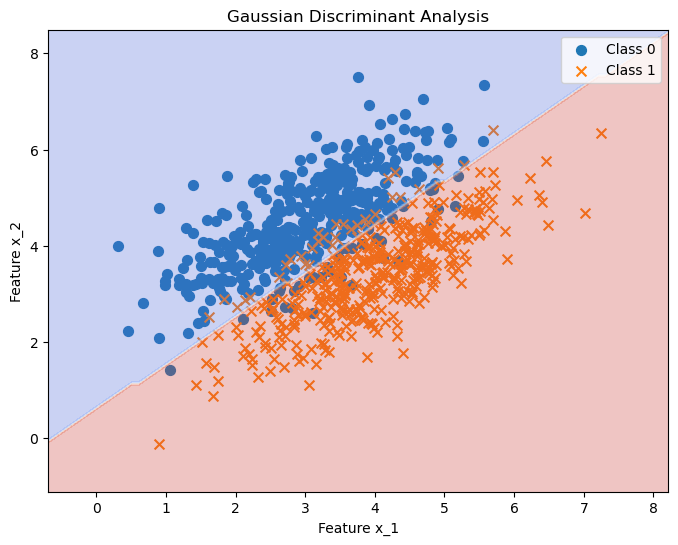

In [18]:
# Plot the training data and decision boundary
plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], label='Class 0', marker='o', s=50)
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], label='Class 1', marker='x', s=50)

# Plot the decision boundary
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = gda_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

plt.xlabel('Feature x_1')
plt.ylabel('Feature x_2')
plt.title('Gaussian Discriminant Analysis')
plt.legend()
plt.show()

# Thank you

---